In [1]:
import warnings
warnings.filterwarnings("ignore")

import torch
from xopt import Xopt

# set values if testing
import os
SMOKE_TEST = os.environ.get("SMOKE_TEST")

YAML = """
generator:
    name: bayesian_exploration

evaluator:
    function: xopt.resources.test_functions.tnk.evaluate_TNK

vocs:
    variables:
        x1: [0, 3.14159]
        x2: [0, 3.14159]
    objectives: {y1: MINIMIZE}
    constraints:
        c1: [GREATER_THAN, 0]
        c2: [LESS_THAN, 0.5]
    constants: {a: dummy_constant}

"""

In [2]:

X = Xopt.from_yaml(YAML)


# for testing purposes only
if SMOKE_TEST:
    X.generator.numerical_optimizer.n_restarts = 1
    X.generator.n_monte_carlo_samples = 1

X


            Xopt
________________________________
Version: 0+untagged.1.gc8a1007
Data size: 0
Config as YAML:
dump_file: null
evaluator:
  function: !!python/name:xopt.resources.test_functions.tnk.evaluate_TNK ''
  function_kwargs:
    raise_probability: 0
    random_sleep: 0
    sleep: 0
  max_workers: 1
  vectorized: false
generator:
  computation_time: null
  fixed_features: null
  max_travel_distances: null
  model: null
  model_constructor:
    covar_modules: {}
    mean_modules: {}
    name: standard
    trainable_mean_keys: []
    use_low_noise_prior: true
  n_candidates: 1
  n_monte_carlo_samples: 128
  name: bayesian_exploration
  numerical_optimizer:
    max_iter: 2000
    n_raw_samples: 20
    n_restarts: 20
    name: LBFGS
  turbo_controller: null
  use_cuda: false
max_evaluations: null
serialize_torch: false
strict: true
vocs:
  constants:
    a: dummy_constant
  constraints:
    c1:
    - GREATER_THAN
    - 0.0
    c2:
    - LESS_THAN
    - 0.5
  objectives:
    y1: MINI

In [3]:
X.random_evaluate(5)

for i in range(5):
    print(f"step {i}")
    X.step()

step 0
step 1
step 2
step 3
step 4


In [4]:
print(X.data)

          x1        x2               a        y1        y2        c1  \
0   0.567388  1.013315  dummy_constant  0.567388  1.013315  0.379528   
1   1.234731  2.220894  dummy_constant  1.234731  2.220894  5.483082   
2   2.643780  0.171593  dummy_constant  2.643780  0.171593  5.968139   
3   0.465361  0.238094  dummy_constant  0.465361  0.238094 -0.755097   
4   0.407004  0.160890  dummy_constant  0.407004  0.160890 -0.905102   
6   0.000000  2.034043             NaN  0.000000  2.034043  3.037332   
7   0.969524  0.343058             NaN  0.969524  0.343058 -0.008955   
8   0.717817  0.936491             NaN  0.717817  0.936491  0.442999   
9   0.963677  0.689438             NaN  0.963677  0.689438  0.491210   
10  0.367902  1.049589             NaN  0.367902  1.049589  0.173969   

          c2  xopt_runtime  xopt_error  
0   0.268033      0.000064       False  
1   3.501308      0.000010       False  
2   4.703644      0.000008       False  
3   0.069794      0.000007       False  
4 

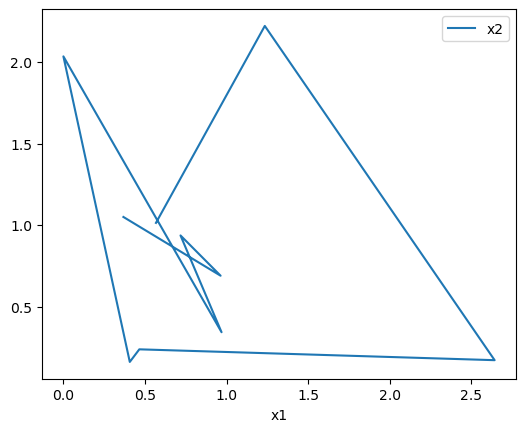

In [5]:
# plot results
ax = X.data.plot("x1", "x2")
ax.set_aspect("equal")

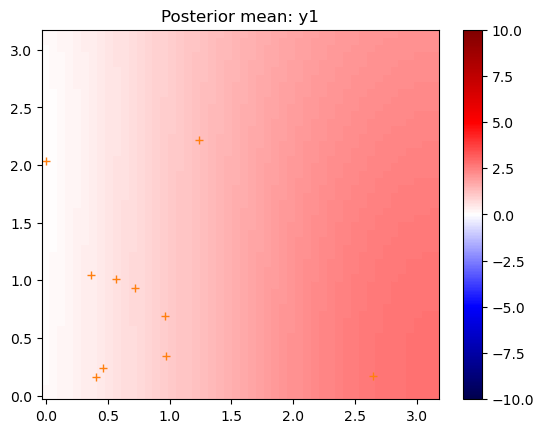

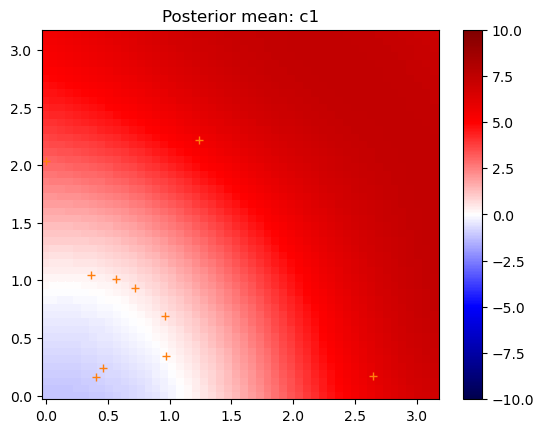

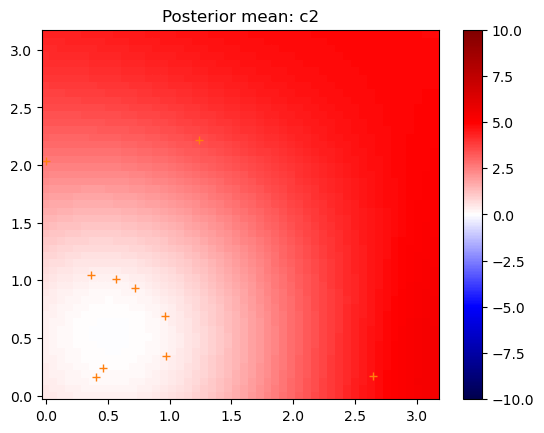

In [6]:
from matplotlib import pyplot as plt  # plot model predictions

data = X.data

bounds = X.generator.vocs.bounds
model = X.generator.model

# create mesh
n = 50
x = torch.linspace(*bounds.T[0], n)
y = torch.linspace(*bounds.T[1], n)
xx, yy = torch.meshgrid(x, y)
pts = torch.hstack([ele.reshape(-1, 1) for ele in (xx, yy)]).double()

outputs = X.generator.vocs.output_names
with torch.no_grad():
    post = model.posterior(pts)

    for i in range(len(X.vocs.output_names)):
        mean = post.mean[...,i]
        fig, ax = plt.subplots()
        ax.plot(*data[["x1", "x2"]].to_numpy().T, "+C1")
        c = ax.pcolor(
            xx, yy, mean.squeeze().reshape(n, n),
            cmap="seismic",
            vmin=-10.0,
            vmax=10.0)
        fig.colorbar(c)
        ax.set_title(f"Posterior mean: {outputs[i]}")

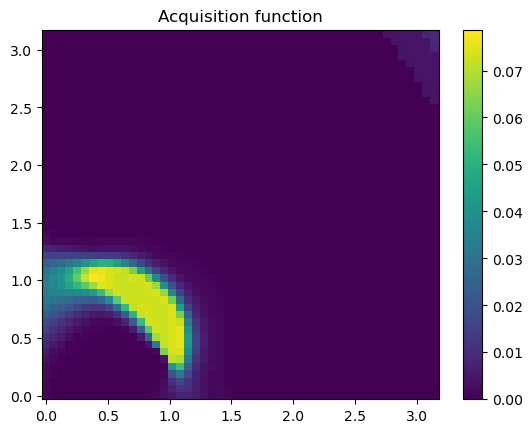

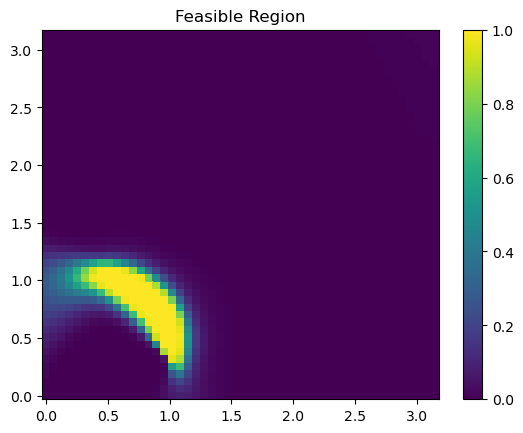

In [7]:
from xopt.generators.bayesian.objectives import feasibility

acq_func = X.generator.get_acquisition(model)
with torch.no_grad():
    acq_pts = pts.unsqueeze(1)
    acq = acq_func(acq_pts)

    fig, ax = plt.subplots()
    c = ax.pcolor(xx, yy, acq.reshape(n, n))
    fig.colorbar(c)
    ax.set_title("Acquisition function")

    feas = feasibility(pts.unsqueeze(1), model, X.vocs).flatten()

    fig2, ax2 = plt.subplots()
    c = ax2.pcolor(xx, yy, feas.reshape(n, n))
    fig2.colorbar(c)
    ax2.set_title("Feasible Region")